In [1]:
import os
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt


@dataclass
class ExpSpec:
    name: str
    results_path: str


@dataclass
class MetricSpec:
    name: str   # display name on y-axis / title
    key: str    # key in txt, e.g., "loss_ED"


def _parse_line(line: str) -> Optional[Tuple[int, Dict[str, float]]]:
    """
    Parse one line like:
      500-loss_ED:0.040987,VQ_C:0.003958,...
    Return (epoch:int, metrics:dict) or None if invalid.
    """
    line = line.strip()
    if not line:
        return None
    # Ignore comments if any
    if line.startswith("#"):
        return None

    if "-" not in line:
        return None

    epoch_str, rest = line.split("-", 1)
    try:
        epoch = int(epoch_str.strip())
    except ValueError:
        return None

    metrics: Dict[str, float] = {}
    for part in rest.split(","):
        part = part.strip()
        if not part or ":" not in part:
            continue
        k, v = part.split(":", 1)
        k = k.strip()
        v = v.strip()
        if not k:
            continue
        try:
            metrics[k] = float(v)
        except ValueError:
            # skip non-float
            continue

    return epoch, metrics


def load_experiment_records(
    results_path: str,
    epoch_range: Tuple[int, int],
) -> Dict[int, Dict[str, float]]:
    """
    Load a record file into:
      {epoch: {key: value, ...}, ...}
    Only keep epochs within [range_start, range_end] inclusive.
    """
    range_start, range_end = epoch_range
    if range_end < range_start:
        raise ValueError(f"Invalid epoch_range: {epoch_range}")

    if not os.path.isfile(results_path):
        raise FileNotFoundError(f"results_path not found: {results_path}")

    by_epoch: Dict[int, Dict[str, float]] = {}

    with open(results_path, "r", encoding="utf-8") as f:
        for raw in f:
            parsed = _parse_line(raw)
            if parsed is None:
                continue
            epoch, metrics = parsed
            if epoch < range_start or epoch > range_end:
                continue
            # if duplicated epoch appears, later line overwrites earlier
            by_epoch[epoch] = metrics

    return by_epoch


def plot_metrics(
    exps: List[Dict],
    metrics: List[Dict],
    epoch_range: Tuple[int, int],
    *,
    save_dir: Optional[str] = None,
    show: bool = True,
    figsize: Tuple[float, float] = (8.0, 4.5),
):
    """
    exps:    [{name:'exp_a', results_path:'a.txt'}, ...]
    metrics: [{name:'recon loss', key:'loss_ED'}, ...]
    epoch_range: (start, end) inclusive
    """
    exp_specs = [ExpSpec(**e) for e in exps]
    metric_specs = [MetricSpec(**m) for m in metrics]

    # Load all experiments once
    exp_data: Dict[str, Dict[int, Dict[str, float]]] = {}
    for exp in exp_specs:
        exp_data[exp.name] = load_experiment_records(exp.results_path, epoch_range)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    # For each metric, draw one figure
    for metric in metric_specs:
        plt.figure(figsize=figsize)
        found_any_in_some_exp = False

        for exp in exp_specs:
            by_epoch = exp_data[exp.name]

            epochs_sorted = sorted(by_epoch.keys())
            xs: List[int] = []
            ys: List[float] = []

            # Track whether this key ever appears in this exp within range
            found_in_this_exp = False

            for ep in epochs_sorted:
                kv = by_epoch[ep]
                if metric.key in kv:
                    found_in_this_exp = True
                    xs.append(ep)
                    ys.append(kv[metric.key])

            if not found_in_this_exp:
                print(f"[WARN] metric key '{metric.key}' NOT found in exp '{exp.name}' "
                      f"(file={exp.results_path}) within range={epoch_range}")
            else:
                found_any_in_some_exp = True

            # Plot (even if empty -> no curve)
            if xs:
                plt.plot(xs, ys, label=exp.name)

        plt.title(metric.name)
        plt.xlabel("epoch")
        plt.ylabel(metric.name)
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        plt.legend()

        # Better x-limits
        plt.xlim(epoch_range[0], epoch_range[1])

        # If absolutely nobody has this key, still save/show an empty plot but warn once
        if not found_any_in_some_exp:
            print(f"[WARN] metric key '{metric.key}' not found in ANY exp within range={epoch_range}")

        if save_dir is not None:
            safe_key = "".join(c if c.isalnum() or c in "-_." else "_" for c in metric.key)
            out_path = os.path.join(save_dir, f"{safe_key}.png")
            plt.tight_layout()
            plt.savefig(out_path, dpi=200)
            print(f"[OK] saved: {out_path}")

        if show:
            plt.show()
        else:
            plt.close()


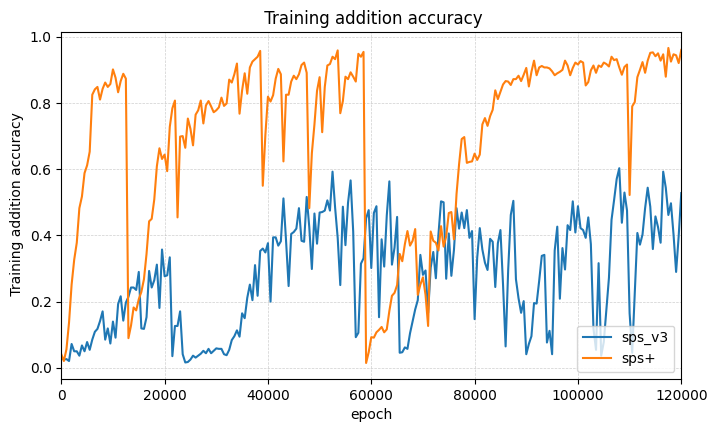

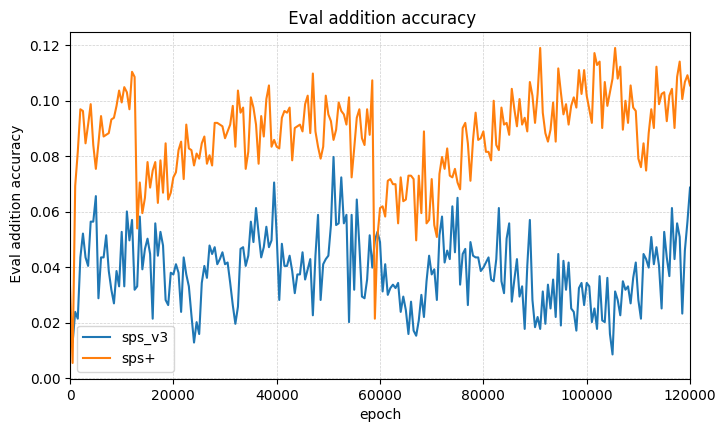

In [4]:
# Example usage
exps = [
    {
        "name": "sps_v3", 
        "results_path": "/home/xuanjie.liu/Projects/S3Plus/VQ/exp/2026.02.05_10vq_Zc[4]_Zs[64]_edim4_[0-20]_plus1024_1_multiStyle_Fullsymm_arabic_v3/1/plus_eval.txt"
    },
    {
        "name": "sps+", 
        "results_path": "/home/xuanjie.liu/Projects/S3Plus/VQ/exp/2026.01.27_10vq_Zc[4]_Zs[64]_edim4_[0-20]_plus1024_1_multiStyle_Fullsymm_arabic/1/plus_eval.txt"
    },
]
metrics = [
    {"name": " Training addition accuracy", "key": "train_emb_select_accu"},
    {"name": " Eval addition accuracy", "key": "eval_emb_select_accu"},
]
epoch_range = (0, 120000)
plot_metrics(
    exps=exps,
    metrics=metrics,
    epoch_range=epoch_range,
    save_dir=None,   # set None if you don't want saving
    show=True,          # set False if running headless
)